In [9]:
import os

In [10]:
!pwd

/home/jovyan/notebooks/analysis/experiment_2


In [11]:
import sys
sys.path.append('/home/jovyan/')

In [12]:
from experiments.reporting.report_repository import ReportRepository
from experiments.slack_client import SlackNotifier
from neat.neat_logger import get_neat_logger
from neat.population_engine import EvolutionEngine
from neat.reporting.reports_pyneat import EvolutionReport
from neat.utils import timeit
import math
import random
from itertools import count
import numpy as np

from experiments.logger import logger
from experiments.slack_client import Notifier
from experiments.object_repository.object_repository import ObjectRepository
from experiments.reporting.report_repository import ReportPathFactory
from neat.configuration import get_configuration
from neat.evaluation.evaluation_engine import EvaluationStochasticEngine
from neat.evolution_operators.crossover import Crossover
from neat.evolution_operators.mutation import Mutation
from neat.genome import Genome
from neat.reporting.reports_pyneat import EvolutionReport
from neat.species import SpeciationEngine
from neat.stagnation import Stagnation
from neat.population_engine import PopulationEngine
from neat.utils import timeit
import neat
import tests
from config_files.configuration_utils import create_configuration
from neat.configuration import get_configuration, set_configuration
from neat.evaluation.evaluation_engine import get_dataset
from neat.evaluation.evaluate_simple import evaluate_genome, calculate_prediction_distribution
from neat.genome import Genome
from neat.evolution_operators.backprop_mutation import BackPropMutation
import os
from neat.loss.vi_loss import get_loss
import torch
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
from neat.analysis.experiment_data import ExperimentDataNE, ExperimentDataNAS
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimator
from neat.analysis.plotting.plot_losses import plot_loss_distribution
from neat.analysis.plotting.plot_classification_metrics import plot_metrics_by_quantile_several_executions
from neat.analysis.experiment_predictive_distributions import ExecutionsPredictionDistributions

In [15]:
LOGS_PATH = f'{os.getcwd()}/'
logger = get_neat_logger(path=LOGS_PATH)

In [16]:
config_versions = {'NE': {'project': 'neuro-evolution',
                         'algorithm_version': 'bayes-neat'},
                  'NAS': {'project': 'nas',
                         'algorithm_version': 'nas'}
                  }
datasets = ['iris', 'wine', 'breast_cancer', 'titanic', 'spambase', 'mnist_downsampled']
df_dataset_sorting = pd.DataFrame(datasets, columns=['dataset']).reset_index().rename(columns={'index': 'order'})
# df_dataset_sorting

In [45]:
version = 10

In [46]:
chunks_ne = []
for dataset in datasets:
    try:
        data_dataset = pd.read_csv(f'data/data_experiment_2_ne_{dataset}_v{version}.csv')
        chunks_ne.append(data_dataset)
    except:
        pass
data_ne = pd.concat(chunks_ne)


chunks_nas = []
for dataset in datasets:
    try:
        data_dataset = pd.read_csv(f'data/data_experiment_2_nas_{dataset}_v{version}.csv')
        chunks_nas.append(data_dataset)
    except:
        pass
data_nas = pd.concat(chunks_nas)

# for dataset, data_dataset in data_nas.groupby('dataset'):
#     data_dataset.to_csv(f'data/data_experiment_2_nas_{dataset}.csv', index=False)
display(data_ne.head(1))
display(data_nas.head(1))

,correlation_id,execution_id,train_percentage,noise,label_noise,is_bayesian,beta,loss_training,loss_testing,duration,...,mean_genome_std,accuracy,precision,recall,f1,ece,absolute_best,version,method,dataset
0,bayesian_neat_ft_final_v1_iris,0f5a1f1c-048b-4e92-bc72-81b00fa4041d,0.75,0.0,0.0,True,0.0001,0.59272,0.84918,0:08:55.735616,...,0.955271,97.368421,0.975232,0.973684,0.973557,0.21087,True,NE,Bayesian-NEAT,iris


,correlation_id,execution_id,train_percentage,noise,label_noise,is_bayesian,beta,duration,end_condition,n_parameters,...,n_connections,n_layers,f1,recall,precision,accuracy,ece,version,method,dataset
0,bayesian_nas_final,04c937ef-f1f6-433c-a501-de48fd5453cf,0.75,0.0,0.0,True,0.000001,0:06:23.322305,normal,326,...,140,2,0.947169,0.947368,0.955466,94.736842,0.046423,NAS,Bayesian-MLP,iris


In [47]:
from scipy import stats
def filter_data(data, filter_noisy=False, z_score=3):
#     data = data.loc[data['f1'] >= filter_threshold]
    chunks = []
    for _, df in data.groupby(['method', 'label_noise']):
#         df[(np.abs(stats.zscore(df['f1'])) < 3).all(axis=1)]
        df = df.loc[np.abs(stats.zscore(df['f1'])) < z_score]
        chunks.append(df)
    data = pd.concat(chunks)
    if filter_noisy:
        data = data.loc[(data['noise'] == 0) &
               (data['label_noise'] == 0)]
    
    
    return data

Filter noisy executions

In [48]:
data_ne = data_ne.loc[(data_ne['noise'] == 0) &
                     (data_ne['label_noise'] == 0)]
data_nas = data_nas.loc[(data_nas['noise'] == 0) &
                     (data_nas['label_noise'] == 0)]

----
# Experiment 2

In [49]:
method_order = ['MLP', 'Bayesian-MLP', 'NEAT', 'Bayesian-NEAT']

In [50]:
data = pd.concat([data_ne, data_nas])
display(data.shape)
data = filter_data(data, filter_noisy=True, z_score=4)
data.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(160, 25)

(160, 25)

In [51]:
data.loc[data['is_bayesian'] == False, 'n_parameters'] = data.loc[data['is_bayesian'] == False, 'n_parameters'] /2
data['duration'] = pd.to_timedelta(data['duration'])
data['duration_s'] = data['duration'].values.astype(np.int64) / 1e9
data['graph_elements'] = data['n_connections'] + data['n_nodes']
data.loc[data['method'].isin(['MLP', 'Bayesian-MLP']), 'duration_s'] = data.loc[data['method'].isin(['MLP', 'Bayesian-MLP']), 'duration_s'] / 8 * 40

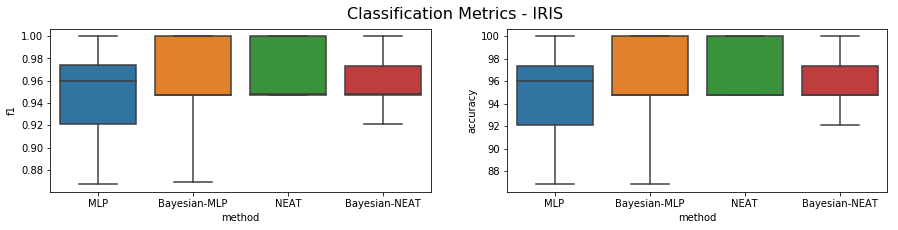

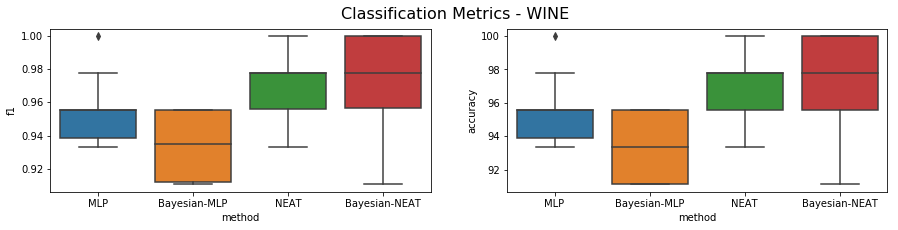

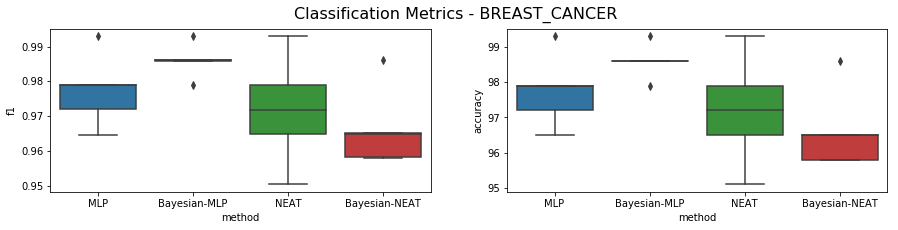

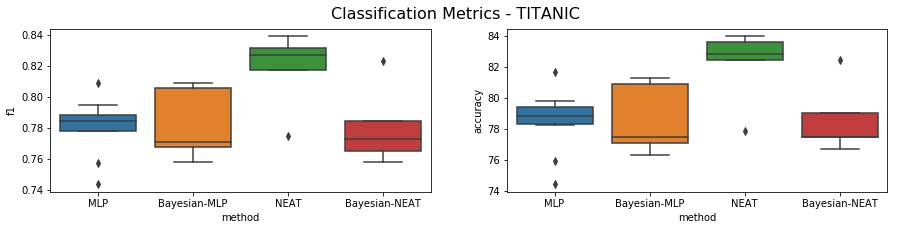

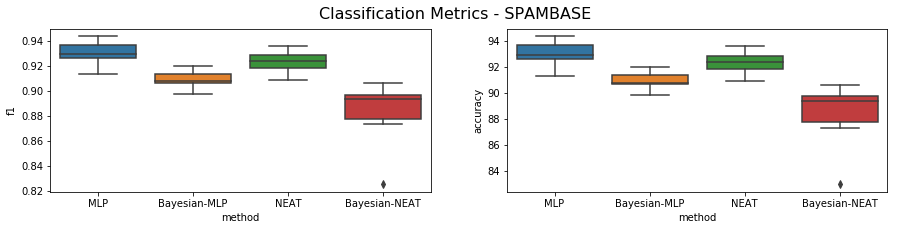

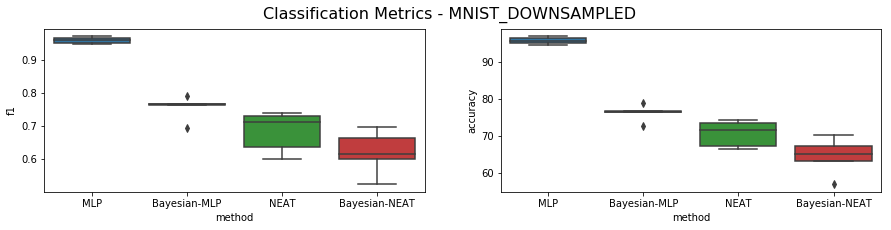

In [52]:
n_datasets = len(data['dataset'].unique())

for i, dataset in enumerate(datasets):
    data_dataset = data.loc[data['dataset'] == dataset]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
    fig.suptitle(f'Classification Metrics - {dataset.upper()}', fontsize=16)

    sns.boxplot(data=data_dataset, x='method', y='f1', ax=ax1, order=method_order)
    sns.boxplot(data=data_dataset, x='method', y='accuracy', ax=ax2, order=method_order)
    plt.savefig(f'./experiment_2_metrics_{dataset}.png')
    plt.show()

In [53]:

# data['duration']

In [54]:
metrics_stats = data.groupby(['dataset', 'method']).agg({'f1': [np.mean, np.std],
                                                        'accuracy': [np.mean, np.std],
                                                        'n_parameters': [np.mean, np.std],
                                                        'n_nodes': [np.mean, np.std],
                                                        'n_connections': [np.mean, np.std],
                                                        'n_layers': [np.mean, np.std],
                                                         'graph_elements': [np.mean, np.std],
                                                        'duration_s': [np.mean, np.std]})
metrics_stats

f1             accuracy            \
                                     mean       std       mean       std   
dataset           method                                                   
breast_cancer     Bayesian-MLP   0.985982  0.004990  98.601399  0.494480   
                  Bayesian-NEAT  0.966448  0.011467  96.643357  1.149068   
                  MLP            0.976140  0.008294  97.622378  0.820831   
                  NEAT           0.971846  0.015848  97.202797  1.563684   
iris              Bayesian-MLP   0.952652  0.053746  95.263158  5.393132   
                  Bayesian-NEAT  0.958027  0.029842  95.789474  3.000462   
                  MLP            0.947235  0.035172  94.736842  3.520295   
                  NEAT           0.968563  0.028699  96.842105  2.882750   
mnist_downsampled Bayesian-MLP   0.755991  0.036255  76.240000  2.216303   
                  Bayesian-NEAT  0.620439  0.065960  64.416000  4.984263   
                  MLP            0.957968  0.008550  95.800000  0.855206   
                  NEAT           0.683041  0.061592  70.496000  3.603731   
spambase          Bayesian-MLP   0.908726  0.008342  90.947003  0.813625   
                  Bayesian-NEAT  0.881117  0.029584  88.242108  2.805955   
                  MLP            0.929950  0.008989  92.988705  0.900149   
                  NEAT           0.922975  0.011405  92.311034  1.118259   
titanic           Bayesian-MLP   0.782351  0.023586  78.625954  2.305925   
                  Bayesian-NEAT  0.780677  0.025687  78.625954  2.290076   
                  MLP            0.780609  0.018510  78.511450  2.020058   
                  NEAT           0.818103  0.025362  82.137405  2.464715   
wine              Bayesian-MLP   0.933602  0.022203  93.333333  2.222222   
                  Bayesian-NEAT  0.969041  0.037330  96.888889  3.718489   
                  MLP            0.955357  0.021055  95.555556  2.095131   
                  NEAT           0.968971  0.025374  96.888889  2.533723   

                                n_parameters             n_nodes             \
                                        mean         std    mean        std   
dataset           method                                                      
breast_cancer     Bayesian-MLP       1204.00  659.317829   24.00  12.549900   
                  Bayesian-NEAT       144.80   24.232210   17.20   3.834058   
                  MLP                 551.50  372.271183   23.50  14.346893   
                  NEAT                 93.40   16.087262   24.20   4.868265   
iris              Bayesian-MLP        402.00  187.829710   24.00   5.477226   
                  Bayesian-NEAT        61.20   13.682105    8.20   2.280351   
                  MLP                 241.00  214.147023   23.75  12.698425   
                  NEAT                 50.40   14.449913   14.80   4.816638   
mnist_downsampled Bayesian-MLP       3470.00  542.494240   44.00   8.944272   
                  Bayesian-NEAT       637.20   29.482198   32.80   2.387467   
                  MLP                1762.00  216.887067   42.00  10.327956   
                  NEAT                335.20   12.774976   36.80   4.324350   
spambase          Bayesian-MLP        780.00  360.943209   11.00   6.519202   
                  Bayesian-NEAT       369.00  180.752870   47.50  30.091527   
                  MLP                1042.00  415.611999   26.50  11.167910   
                  NEAT                185.75   51.603456   47.25  17.250604   
titanic           Bayesian-MLP        310.00   80.498447   19.00   4.472136   
                  Bayesian-NEAT        96.40   17.285832   13.40   2.880972   
                  MLP                 233.00  215.313725   21.50  12.791056   
                  NEAT                 83.60   25.224988   25.20   8.408329   
wine              Bayesian-MLP        600.00  276.097809   22.00   7.416198   
                  Bayesian-NEAT       198.00   24.372115   22.00   4.062019   
           

In [55]:
# f1 = metrics_stats['f1'].reset_index()
# f1['metric'] = 'f1'

# accuracy = metrics_stats['accuracy'].reset_index()
# accuracy['metric'] = 'accuracy'
# metrics_classif = pd.concat([f1, accuracy]).drop(columns=['std'])
# metrics_classif.head(1)

In [56]:
def sort_df_by_dataset(df):
    df = df.merge(df_dataset_sorting, on='dataset').sort_values('order', ascending=True).drop(columns=['order'])
    return df

In [57]:
f1 = pd.pivot_table(data=metrics_stats['f1'].reset_index(), index=['dataset'], values=['mean'], columns=['method'])['mean'].reset_index()
f1 = f1[['dataset'] + method_order]
f1 = sort_df_by_dataset(f1)
display(f1)
f1.to_latex('mean_f1.txt', index=False)

,dataset,MLP,Bayesian-MLP,NEAT,Bayesian-NEAT
1,iris,0.947235,0.952652,0.968563,0.958027
5,wine,0.955357,0.933602,0.968971,0.969041
0,breast_cancer,0.976140,0.985982,0.971846,0.966448
4,titanic,0.780609,0.782351,0.818103,0.780677
3,spambase,0.929950,0.908726,0.922975,0.881117
2,mnist_downsampled,0.957968,0.755991,0.683041,0.620439


In [31]:
accuracy = pd.pivot_table(data=metrics_stats['accuracy'].reset_index(), index=['dataset'], values=['mean'], columns=['method'])['mean'].reset_index()
accuracy = accuracy[['dataset'] + method_order]
accuracy = sort_df_by_dataset(accuracy)
display(accuracy)
accuracy.to_latex('mean_accuracy.txt', index=False)

,dataset,MLP,Bayesian-MLP,NEAT,Bayesian-NEAT
1,iris,94.736842,96.315789,96.842105,95.263158
5,wine,95.555556,94.666667,96.888889,96.888889
0,breast_cancer,97.622378,98.181818,97.202797,96.503497
4,titanic,78.511450,79.770992,82.137405,78.702290
3,spambase,92.988705,92.215465,92.311034,88.300029
2,mnist_downsampled,95.800000,78.080000,70.512000,64.240000


---
### Study ARCHITECTURE

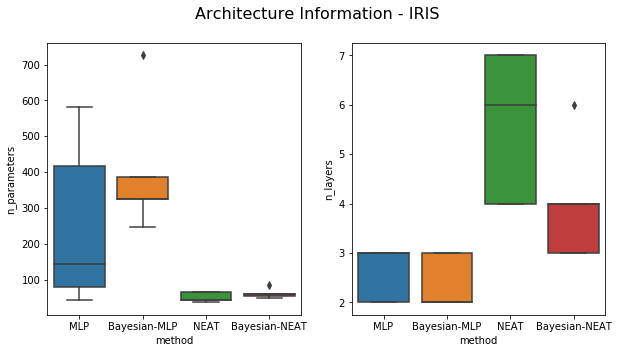

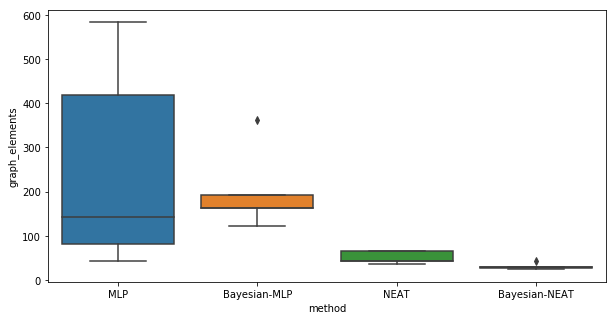

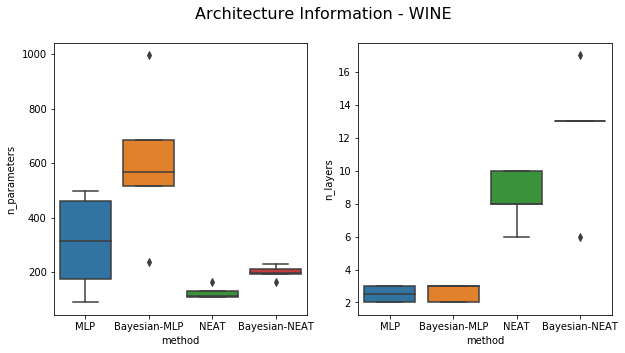

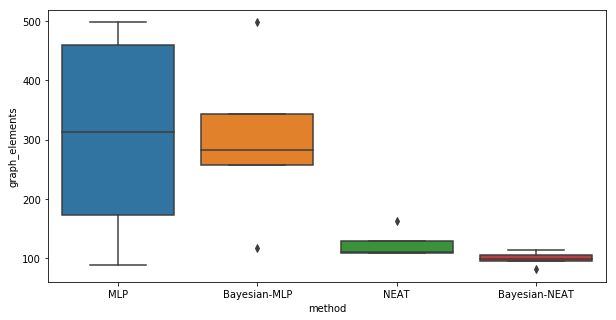

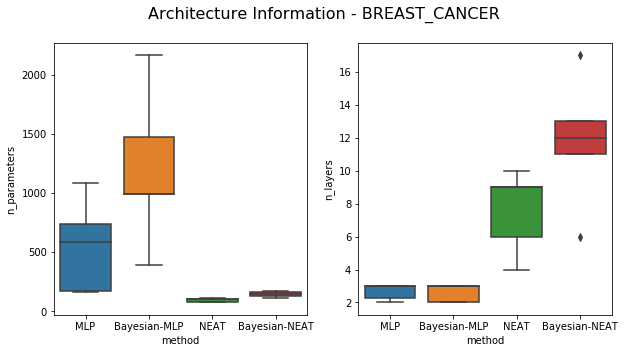

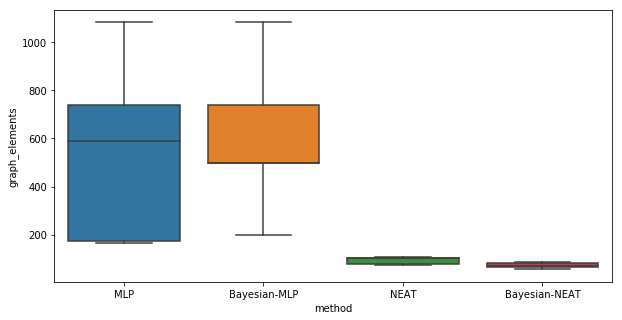

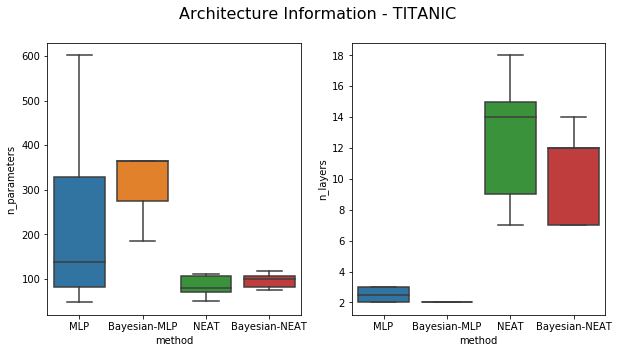

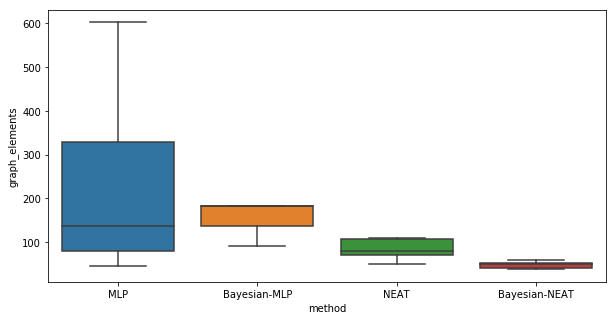

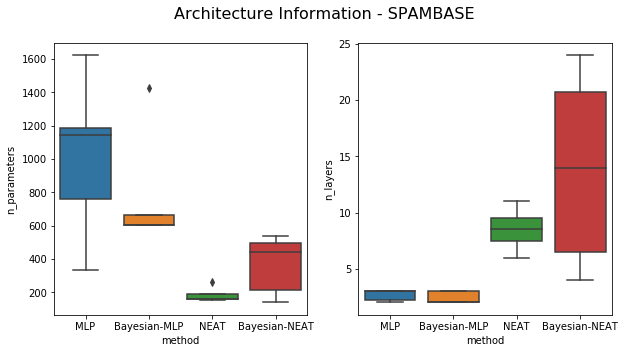

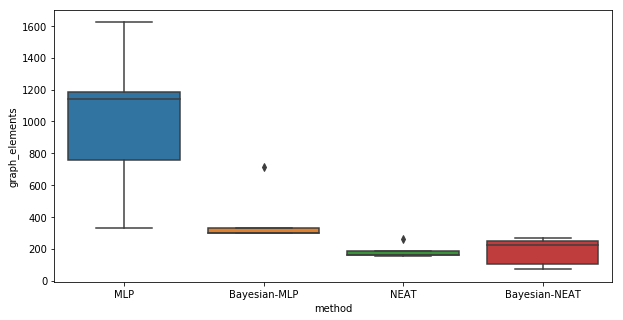

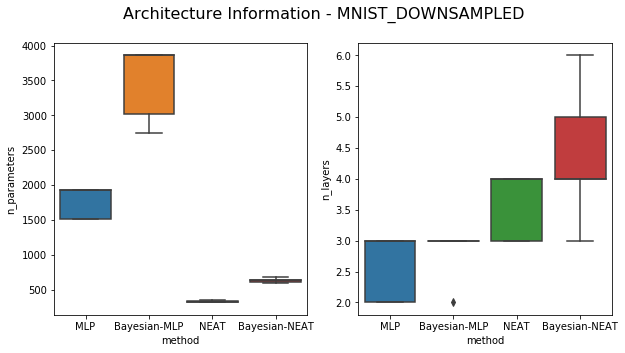

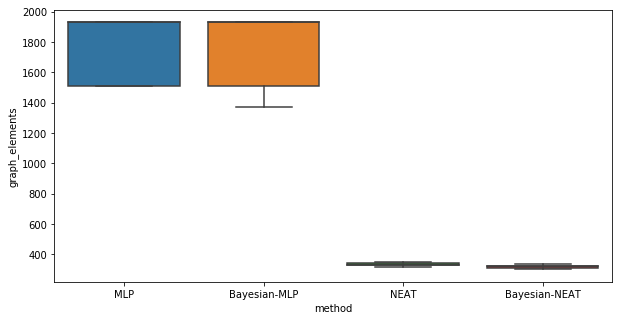

In [58]:
n_datasets = len(data['dataset'].unique())

for i, dataset in enumerate(datasets):
    data_dataset = data.loc[data['dataset'] == dataset]
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
#     fig.suptitle(f'Architecture Information - {dataset.upper()}', fontsize=16)

#     sns.boxplot(data=data_dataset, x='method', y='n_parameters', ax=ax1, order=method_order)
#     sns.boxplot(data=data_dataset, x='method', y='n_layers', ax=ax2, order=method_order)
#     sns.boxplot(data=data_dataset, x='method', y='n_nodes', ax=ax3, order=method_order)
#     sns.boxplot(data=data_dataset, x='method', y='n_connections', ax=ax4, order=method_order)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'Architecture Information - {dataset.upper()}', fontsize=16)

    sns.boxplot(data=data_dataset, x='method', y='n_parameters', ax=ax1, order=method_order)
    sns.boxplot(data=data_dataset, x='method', y='n_layers', ax=ax2, order=method_order)
    plt.savefig(f'./experiment_2_architecture_1_{dataset}.png')

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.boxplot(data=data_dataset, x='method', y='graph_elements', ax=ax, order=method_order)
    plt.savefig(f'./experiment_2_architecture_2_{dataset}.png')

    plt.show()

In [23]:
n_parameters = pd.pivot_table(data=metrics_stats['n_parameters'].reset_index(), index=['dataset'], values=['mean'], columns=['method'])['mean'].reset_index()
n_parameters = n_parameters[['dataset'] + method_order]
n_parameters = sort_df_by_dataset(n_parameters)
display(n_parameters)
n_parameters.to_latex('mean_n_parameters.txt', index=False)

,dataset,MLP,Bayesian-MLP,NEAT,Bayesian-NEAT
1,iris,241.0,402.0,50.40,61.2
5,wine,301.5,600.0,123.60,198.0
0,breast_cancer,551.5,1204.0,93.40,144.8
4,titanic,233.0,310.0,83.60,96.4
3,spambase,1042.0,780.0,185.75,369.0
2,mnist_downsampled,1762.0,3470.0,335.20,637.2


In [24]:
graph_elements = pd.pivot_table(data=metrics_stats['graph_elements'].reset_index(), index=['dataset'], values=['mean'], columns=['method'])['mean'].reset_index()
graph_elements = graph_elements[['dataset'] + method_order]
graph_elements = sort_df_by_dataset(graph_elements)
display(graph_elements)
graph_elements.to_latex('mean_graph_elements.txt', index=False)

,dataset,MLP,Bayesian-MLP,NEAT,Bayesian-NEAT
1,iris,241.0,201.0,50.40,30.6
5,wine,301.5,300.0,123.60,99.0
0,breast_cancer,551.5,602.0,93.40,72.4
4,titanic,233.0,155.0,83.60,48.2
3,spambase,1042.0,390.0,185.75,184.5
2,mnist_downsampled,1762.0,1735.0,335.20,318.6


In [25]:
n_layers = pd.pivot_table(data=metrics_stats['n_layers'].reset_index(), index=['dataset'], values=['mean'], columns=['method'])['mean'].reset_index()
n_layers = n_layers[['dataset'] + method_order]
n_layers = sort_df_by_dataset(n_layers)
display(n_layers)
n_layers.to_latex('mean_n_layers.txt', index=False)

,dataset,MLP,Bayesian-MLP,NEAT,Bayesian-NEAT
1,iris,2.6,2.4,5.6,4.000000
5,wine,2.5,2.6,8.4,12.400000
0,breast_cancer,2.7,2.6,7.6,11.800000
4,titanic,2.5,2.0,12.6,10.400000
3,spambase,2.7,2.4,8.5,13.833333
2,mnist_downsampled,2.6,2.8,3.6,4.400000


---
# Study Wall-clock Time

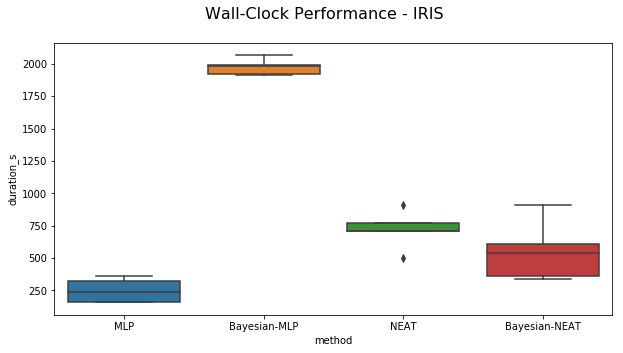

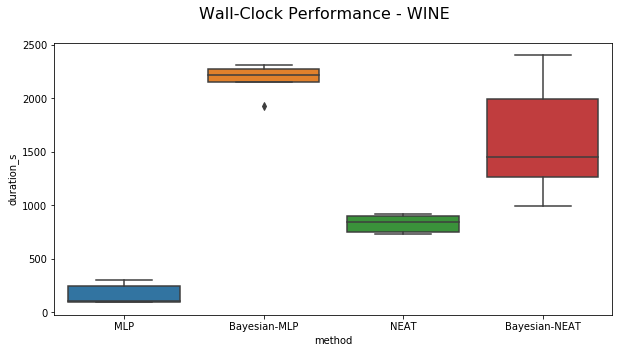

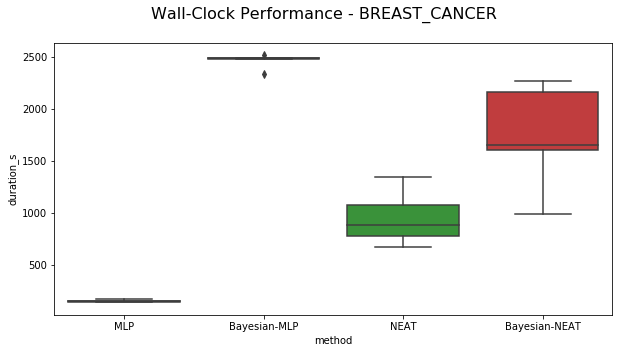

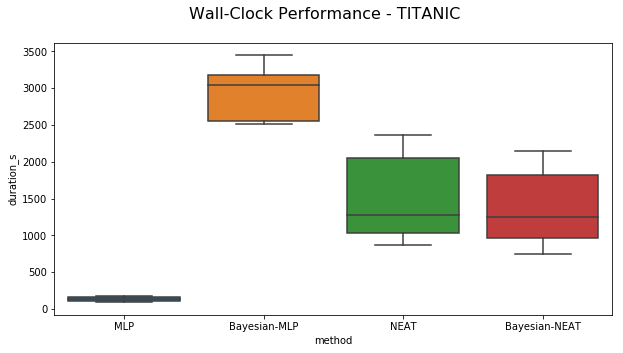

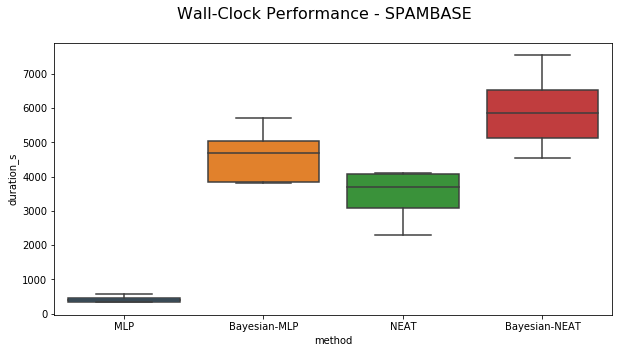

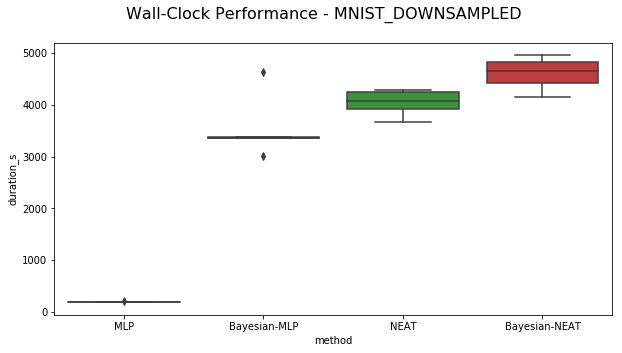

In [27]:
n_datasets = len(data['dataset'].unique())

for i, dataset in enumerate(datasets):
    data_dataset = data.loc[data['dataset'] == dataset]

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle(f'Wall-Clock Performance - {dataset.upper()}', fontsize=16)

    sns.boxplot(data=data_dataset, x='method', y='duration_s', ax=ax, order=method_order)

    plt.show()

In [31]:
duration_s = pd.pivot_table(data=metrics_stats['duration_s'].reset_index(), index=['dataset'], values=['mean'], columns=['method'])['mean'].reset_index()
duration_s = duration_s[['dataset'] + method_order]
duration_s = sort_df_by_dataset(duration_s)
display(duration_s)
duration_s.to_latex('mean_duration_s.txt', index=False)

,dataset,MLP,Bayesian-MLP,NEAT,Bayesian-NEAT
1,iris,1241.901508,9871.696930,720.154666,551.061818
5,wine,826.896283,10886.915430,828.307884,1621.904018
0,breast_cancer,768.815355,12316.316180,950.048351,1738.091945
4,titanic,679.185043,14736.049415,1519.491751,1387.155782
3,spambase,2104.796775,23112.496065,3455.978570,5903.868302
2,mnist_downsampled,931.212055,17742.326820,4041.029788,4603.401576
